# **Neural Style Transfer**

  Archie Agarwal

In [1]:
!pip3 install cython
!pip3 install tensornets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 651.1/651.1 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tensornets: filename=tensornets-0.4.6-cp310-cp310-linux_x86_64.whl size=1495651 sha256=e3de0b385ea9c651565fe9976f0f6f865e93d4b4af0355e06377ed892271982a
  Stored in directory: /root/.cache/pip/wheels/01/a5/1c/0b56f70e458ba833b02ed125cf5c5c9240175cbd9fe7af66c8
Successfully built tensornets


In [2]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.0 MB/s eta 0:00:00


### **Importing modules**

In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from keras import applications as ap
import IPython.display
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
from PIL import Image,ImageTk
import os
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [4]:
# Ensure TensorFlow is running in eager mode
tf.config.run_functions_eagerly(True)

### **Utility Function**

In [5]:
def load_img(path):
    input_size = (224, 224)
    img = Image.open(path)
    img = img.resize(input_size, Image.ANTIALIAS)
    img = np.array(img)[...,:3]
    img = img.astype('float32')
    return img

In [6]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68
    img = img[:, :, ::-1]
    img = np.expand_dims(img, axis=0)
    return img

In [7]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### **Load VGG19 model pre-trained on ImageNet**

In [8]:
vgg = VGG19(weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 4s 0us/step


### **Defining Content and Style layers from pretrained model**

In [9]:
# Define the model to output content and style layer activations
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

In [10]:
output_layers = style_layers + content_layers
model_outputs = [vgg.get_layer(name).output for name in output_layers]
model = Model(inputs=vgg.input, outputs=model_outputs)

### **Function: get_feature_representations**

In [11]:
def get_feature_representations(model, content_path, style_path):
    # Load and process the content and style images
    # This function likely loads the image from the given path and processes it into a format compatible with the model
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # Compute content and style features
    # Pass the style image through the model to get the style features
    style_outputs = model(style_image)
    # Pass the content image through the model to get the content features
    content_outputs = model(content_image)

    # Extract the features for the style layers from the model outputs
    # Assuming style_layers contains the indices of layers that capture style features
    style_features = [style_layer for style_layer in style_outputs[:len(style_layers)]]
    # Extract the features for the content layers from the model outputs
    # Assuming content layers are after the style layers in the model outputs
    content_features = [content_layer for content_layer in content_outputs[len(style_layers):]]

    return style_features, content_features


### **Compute Gram matrix**

In [12]:

def compute_gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    return tf.matmul(a, a, transpose_a=True) / tf.cast(n * n, tf.float32)


### **Style Loss**

In [13]:
def get_style_loss(style_features, style_outputs):
    style_loss = 0
    for style_feature, style_output in zip(style_features, style_outputs):
        gram_style = compute_gram_matrix(style_feature)
        gram_output = compute_gram_matrix(style_output)
        style_loss += tf.reduce_sum(tf.square(gram_style - gram_output)) / tf.cast(4 * (style_feature.shape[0] ** 2), tf.float32)
    return style_loss / len(style_features)

### **Content Loss**

In [14]:
def get_content_loss(content_feature, content_output):
    return tf.reduce_mean(tf.square(content_feature - content_output))

### **Total Loss**

In [15]:
#calculating total loss
def get_total_loss(model, loss_weights, init_image, gram_style_features, content_feature):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:len(style_layers)]
    content_output_feature = model_outputs[len(style_layers):]

    style_score = get_style_loss(gram_style_features, style_output_features)
    content_score = get_content_loss(content_feature, content_output_feature[0])

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    return loss, style_score, content_score

### **File upload widgets**

In [16]:
upload_content = widgets.FileUpload(accept='image/*', multiple=False)
upload_style = widgets.FileUpload(accept='image/*', multiple=False)

In [17]:
def on_upload_change(change):
    global content_img, style_img, content_path, style_path

    if upload_content.value and upload_style.value:  # Check if both content and style images are uploaded
        content_file = list(upload_content.value.values())[0]  # Get the uploaded content image file
        style_file = list(upload_style.value.values())[0]  # Get the uploaded style image file

        content_path = 'uploaded_content.jpg'  # Set the path for the uploaded content image
        style_path = 'uploaded_style.jpg'  # Set the path for the uploaded style image

        with open(content_path, 'wb') as f:  # Write the content image to a file
            f.write(content_file['content'])

        with open(style_path, 'wb') as f:  # Write the style image to a file
            f.write(style_file['content'])

        content_img = load_and_process_img(content_path)  # Load and process the content image
        style_img = load_and_process_img(style_path)  # Load and process the style image

        display_images(content_path, style_path)  # Display the content and style images

        # Proceed with style transfer
        perform_style_transfer()  # Perform style transfer using the processed images


In [18]:
def display_images(content_path, style_path):
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    content_image = Image.open(content_path)
    style_image = Image.open(style_path)
    ax[0].imshow(content_image)
    ax[0].set_title('Content Image')
    ax[1].imshow(style_image)
    ax[1].set_title('Style Image')
    plt.show()

In [19]:
def perform_style_transfer():
    # Get the style and content feature representations from the model
    style_features, content_features = get_feature_representations(model, content_path, style_path)

    # Initialize the image to be optimized with the content image
    init_image = tf.Variable(content_img, dtype=tf.float32)

    # Define the optimizer
    opt = Adam(learning_rate=10.0)

    # Set the number of epochs and steps per epoch for training
    epochs = 20
    steps_per_epoch = 100

    # Define the weights for style and content loss
    style_weight = 1e-2
    content_weight = 1e3
    loss_weights = (style_weight, content_weight)

    for epoch in range(epochs):  # Loop over epochs
        for step in range(steps_per_epoch):  # Loop over steps within an epoch
            with tf.GradientTape() as tape:  # Record operations for automatic differentiation
                # Calculate the total loss
                all_loss = get_total_loss(model, loss_weights, init_image, style_features, content_features[0])

            total_loss = all_loss[0]  # Extract total loss
            content_loss = all_loss[2]  # Extract content loss
            style_loss = all_loss[1]  # Extract style loss

            # Calculate gradients of the loss with respect to the initialized image
            grad = tape.gradient(total_loss, init_image)
            # Apply gradients to the initialized image
            opt.apply_gradients([(grad, init_image)])

        # Print the loss values every epoch
        print(f"Epoch {epoch}")
        print(f"TotalLoss: {total_loss}, StyleLoss: {style_loss}, ContentLoss: {content_loss}")
        # Display the current state of the image
        IPython.display.display_png(Image.fromarray(deprocess_img(init_image.numpy())))

    # Deprocess and show the final stylized image
    final_img = deprocess_img(init_image.numpy())
    plt.imshow(final_img)
    plt.show()

### **Upload Function**

In [20]:
upload_content.observe(on_upload_change, names='value')
upload_style.observe(on_upload_change, names='value')

### **Display Uploaded Images**

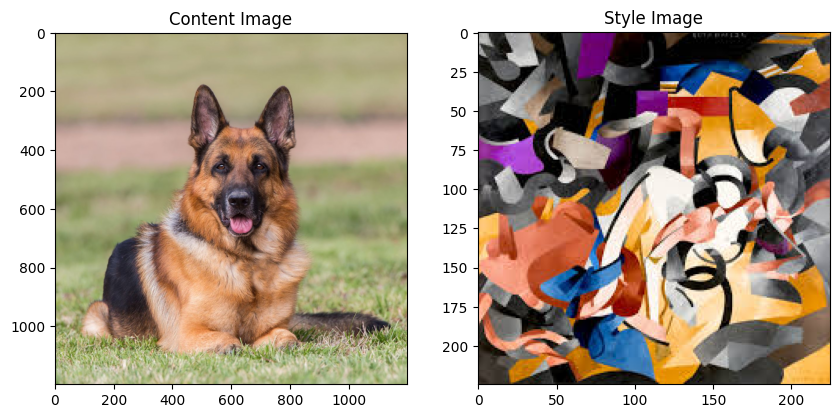

Epoch 0
TotalLoss: 75728.7578125, StyleLoss: 6755.572265625, ContentLoss: 68973.1875


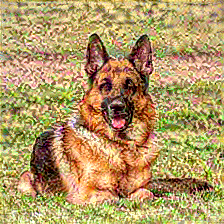

Epoch 1
TotalLoss: 43713.5234375, StyleLoss: 6435.43310546875, ContentLoss: 37278.08984375


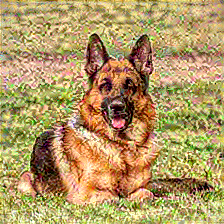

Epoch 2
TotalLoss: 40633.8984375, StyleLoss: 6299.96533203125, ContentLoss: 34333.93359375


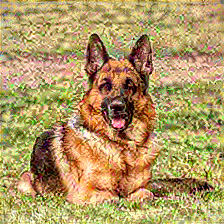

Epoch 3
TotalLoss: 40345.06640625, StyleLoss: 6244.4931640625, ContentLoss: 34100.57421875


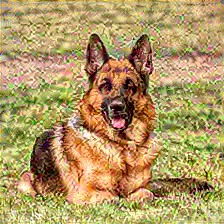

Epoch 4
TotalLoss: 34340.53125, StyleLoss: 6175.046875, ContentLoss: 28165.486328125


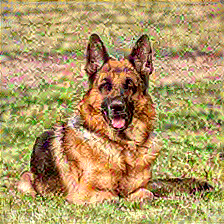

Epoch 5
TotalLoss: 33011.8125, StyleLoss: 6149.80078125, ContentLoss: 26862.01171875


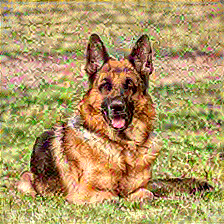

Epoch 6
TotalLoss: 23360.83984375, StyleLoss: 6308.56640625, ContentLoss: 17052.2734375


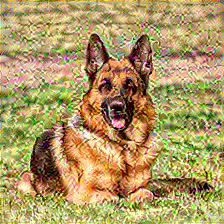

Epoch 7
TotalLoss: 18447.958984375, StyleLoss: 6182.81787109375, ContentLoss: 12265.1416015625


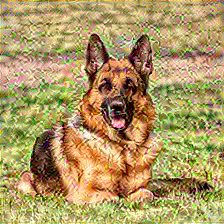

Epoch 8
TotalLoss: 19751.541015625, StyleLoss: 6145.48974609375, ContentLoss: 13606.05078125


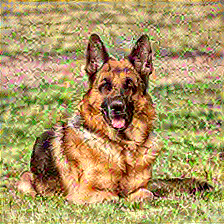

Epoch 9
TotalLoss: 44592.640625, StyleLoss: 6475.44140625, ContentLoss: 38117.19921875


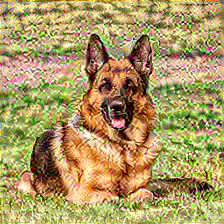

Epoch 10
TotalLoss: 18838.2421875, StyleLoss: 6223.103515625, ContentLoss: 12615.1376953125


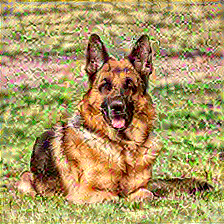

Epoch 11
TotalLoss: 19811.984375, StyleLoss: 6153.6796875, ContentLoss: 13658.3046875


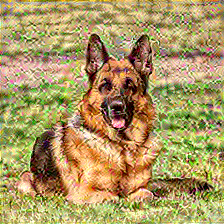

Epoch 12
TotalLoss: 26476.091796875, StyleLoss: 6198.43359375, ContentLoss: 20277.658203125


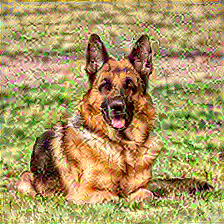

Epoch 13
TotalLoss: 22559.33984375, StyleLoss: 6144.37890625, ContentLoss: 16414.9609375


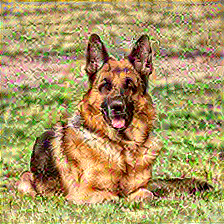

Epoch 14
TotalLoss: 17269.115234375, StyleLoss: 6142.18994140625, ContentLoss: 11126.92578125


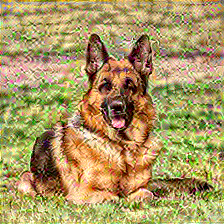

Epoch 15
TotalLoss: 16604.544921875, StyleLoss: 6082.63330078125, ContentLoss: 10521.9111328125


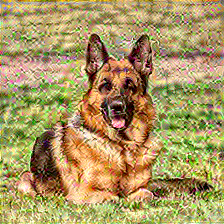

Epoch 16
TotalLoss: 104724.078125, StyleLoss: 7971.73193359375, ContentLoss: 96752.34375


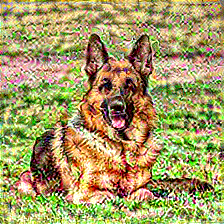

Epoch 17
TotalLoss: 27532.681640625, StyleLoss: 6955.87646484375, ContentLoss: 20576.8046875


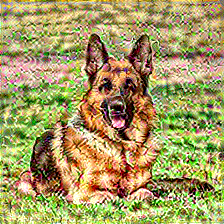

Epoch 18
TotalLoss: 22280.37890625, StyleLoss: 6652.20458984375, ContentLoss: 15628.173828125


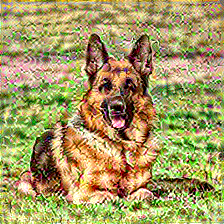

Epoch 19
TotalLoss: 21456.421875, StyleLoss: 6500.52978515625, ContentLoss: 14955.892578125


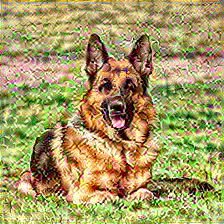

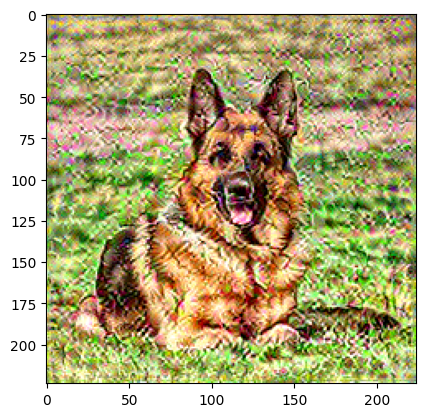

In [27]:
display(widgets.VBox([widgets.Label("Upload Content Image"), upload_content,
                      widgets.Label("Upload Style Image"), upload_style]))